In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pytest
#!pip install ipytest
import ipytest


In [2]:
!ls -l

total 1352
-rw-r--r--  1 federicomoreno  staff   10205 May 10 10:54 EDA_requests.ipynb
-rw-r--r--  1 federicomoreno  staff  328685 May 10 10:20 golang_api_data.csv
-rw-r--r--  1 federicomoreno  staff  334734 May 10 10:20 python_api_data.csv
-rw-r--r--  1 federicomoreno  staff    6804 May 10 10:17 request_apis.ipynb


In [3]:
df_python = pd.read_csv('python_api_data.csv')
df_go = pd.read_csv('golang_api_data.csv')

# Count of APIs
## Locks vs Atomic

Podemos ver que la api de python que usa lock para contar no tiene consistencia a la hora de devolver el count. Python no devuelve secuenciales en cambio go lang con atomics devuelve el conteo secuencial a pesar de haber hecho requests concurrentes. De hecho solo hice 1000 y python no lleva bien el conteo.

In [4]:
df_python.sort_values(by="count",ascending=True)


,response_code,reponse_hour,count,response_time
2,405,17:42:44,6,135.043701
1,405,17:42:44,7,77.796875
0,405,17:42:44,8,87.667236
3,405,17:42:44,10,78.639160
4,405,17:42:44,10,145.483887
...,...,...,...,...
9995,405,17:45:06,19993,27.715820
9996,405,17:45:06,19996,50.090088
9997,405,17:45:06,19998,29.742188
9998,405,17:45:06,19999,38.071045


In [5]:
df_go.sort_values(by="count",ascending=True,inplace=True)

In [6]:
#lag column
df_go['lag'] = df_go['count'].shift(1)
#diff column
df_go['diff'] = df_go['count'] - df_go['lag']
(df_go['diff'] != 1).sum()

1

In [7]:
df_go[df_go['diff'] != 1]

,response_code,reponse_hour,count,response_time,lag,diff
2,405,17:45:06,1,158.510986,NaN,NaN


In [8]:
df_python.sort_values(by="count",ascending=True,inplace=True)
df_python['lag'] = df_python['count'].shift(1)
df_python['diff'] = df_python['count'] - df_python['lag']
(df_python['diff'] != 1).sum()

7820

In [9]:
df_python[df_python['diff'] != 1]

,response_code,reponse_hour,count,response_time,lag,diff
2,405,17:42:44,6,135.043701,NaN,NaN
3,405,17:42:44,10,78.639160,8.0,2.0
4,405,17:42:44,10,145.483887,10.0,0.0
5,405,17:42:44,17,53.274658,10.0,7.0
6,405,17:42:44,17,51.327881,17.0,0.0
...,...,...,...,...,...,...
9993,405,17:45:06,19991,32.072998,19991.0,0.0
9994,405,17:45:06,19993,17.624023,19991.0,2.0
9995,405,17:45:06,19993,27.715820,19993.0,0.0
9996,405,17:45:06,19996,50.090088,19993.0,3.0


Como vemos en el resultado el count no se mantiene consistente en Python

## Comparacion de tiempos

In [10]:
df_go.sort_values(by="response_time",ascending=True)
#decile of count
df_go['decile'] = pd.qcut(df_go['response_time'],10,labels=False)
#grouby decile and mean of response time
df_go_mean = df_go.groupby('decile',as_index=False)['response_time'].mean()
df_go_mean = df_go_mean.rename(columns={'response_time':'mean_response_go_atomic'})

In [11]:
df_python.sort_values(by="response_time",ascending=True)
#decile of count
df_python['decile'] = pd.qcut(df_python['response_time'],10,labels=False)
#grouby decile and mean of response time
df_python_mean = df_python.groupby('decile',as_index=False)['response_time'].mean()
df_python_mean = df_python_mean.rename(columns={'response_time':'mean_response_python'})

In [12]:
#merge
df = pd.merge(df_go_mean,df_python_mean,on='decile')
df

,decile,mean_response_go_atomic,mean_response_python
0,0,10.452243,17.504341
1,1,12.279624,20.720865
2,2,13.637510,23.029678
3,3,14.798229,25.343028
4,4,15.922962,27.891400
5,5,17.114794,30.856890
6,6,18.557352,34.458765
7,7,20.597139,40.057150
8,8,24.156473,49.413270
9,9,63.594405,87.074668


<AxesSubplot:xlabel='decile'>

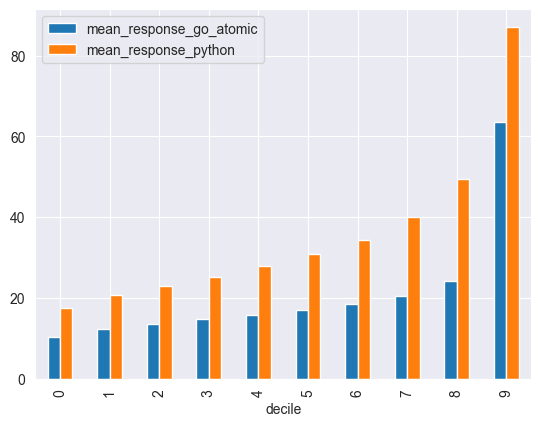

In [13]:
df.plot.bar(x='decile',y=['mean_response_go_atomic','mean_response_python'])

# Boxplot

Golang tiene una distribucion mas normal que python. Python tiene una distribucion mas sesgada a la derecha. Sin embargo hay un valor mayor de outliers en golang.

/Users/federicomoreno/.pyenv/versions/3.10.6/envs/fede_310/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/federicomoreno/.pyenv/versions/3.10.6/envs/fede_310/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


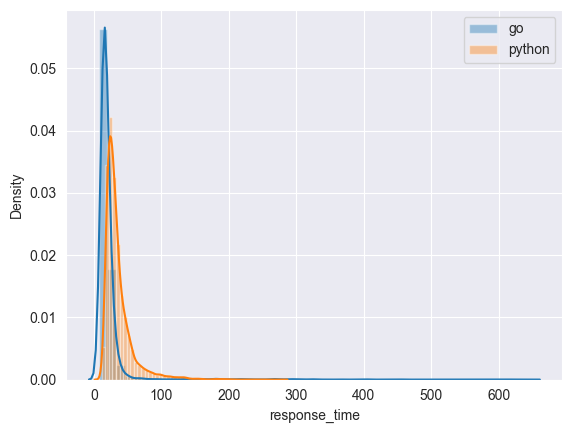

In [14]:
#cont
df_go['language'] = 'go'
df_python['language'] = 'python'
df_box = pd.concat([df_go,df_python])
#boxplot
sns.distplot(df_box[df_box['language']=='go']['response_time'],label='go')
sns.distplot(df_box[df_box['language']=='python']['response_time'],label='python')
plt.legend()
plt.show()

In [15]:
#merge df_go and df_python by index
df_compare = pd.merge(df_go,df_python,left_index=True,right_index=True,suffixes=('_go','_python'))
df_compare

,response_code_go,reponse_hour_go,count_go,response_time_go,lag_go,diff_go,decile_go,language_go,response_code_python,reponse_hour_python,count_python,response_time_python,lag_python,diff_python,decile_python,language_python
2,405,17:45:06,1,158.510986,NaN,NaN,9,go,405,17:42:44,6,135.043701,NaN,NaN,9,python
3,405,17:45:06,2,159.871826,1.0,1.0,9,go,405,17:42:44,10,78.639160,8.0,2.0,9,python
5,405,17:45:06,3,156.963135,2.0,1.0,9,go,405,17:42:44,17,53.274658,10.0,7.0,8,python
6,405,17:45:06,4,182.351074,3.0,1.0,9,go,405,17:42:44,17,51.327881,17.0,0.0,8,python
0,405,17:45:06,5,179.286865,4.0,1.0,9,go,405,17:42:44,8,87.667236,7.0,1.0,9,python
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,405,17:46:30,9996,13.609863,9995.0,1.0,2,go,405,17:45:06,19993,27.715820,19993.0,0.0,4,python
9996,405,17:46:30,9997,12.890137,9996.0,1.0,1,go,405,17:45:06,19996,50.090088,19993.0,3.0,8,python
9997,405,17:46:30,9998,11.196777,9997.0,1.0,0,go,405,17:45:06,19998,29.742188,19996.0,2.0,5,python
9999,405,17:46:30,9999,8.937744,9998.0,1.0,0,go,405,17:45:06,20000,29.063965,19999.0,1.0,4,python


In [16]:
df_compare["delay_golang"] = np.where(df_compare["response_time_go"] > df_compare["response_time_python"], df_compare["response_time_go"] - df_compare["response_time_python"], 0)
#filter delay_golang > 0
df_compare_delay = df_compare[df_compare['delay_golang']>0]

In [17]:
df_compare_delay.sort_values(by="delay_golang",ascending=False)


,response_code_go,reponse_hour_go,count_go,response_time_go,lag_go,diff_go,decile_go,language_go,response_code_python,reponse_hour_python,count_python,response_time_python,lag_python,diff_python,decile_python,language_python,delay_golang
8649,405,17:46:22,8650,646.160889,8649.0,1.0,9,go,405,17:44:46,17305,58.397949,17305.0,0.0,9,python,587.762939
9874,405,17:46:29,9876,620.915039,9875.0,1.0,9,go,405,17:45:04,19757,42.458252,19748.0,9.0,7,python,578.456787
6390,405,17:45:59,6391,639.630127,6390.0,1.0,9,go,405,17:44:07,12784,72.603027,12784.0,0.0,9,python,567.027100
6389,405,17:45:59,6390,637.332031,6389.0,1.0,9,go,405,17:44:07,12784,74.112061,12780.0,4.0,9,python,563.219971
9875,405,17:46:29,9875,620.103760,9874.0,1.0,9,go,405,17:45:04,19757,62.017090,19757.0,0.0,9,python,558.086670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,405,17:45:35,3616,17.334961,3615.0,1.0,5,go,405,17:43:30,7236,17.284180,7231.0,5.0,0,python,0.050781
5164,405,17:45:49,5167,16.129883,5166.0,1.0,4,go,405,17:43:47,10333,16.080811,10331.0,2.0,0,python,0.049072
6041,405,17:45:56,6042,30.435791,6041.0,1.0,9,go,405,17:43:57,12087,30.392090,12087.0,0.0,5,python,0.043701
5820,405,17:45:54,5821,18.671143,5820.0,1.0,6,go,405,17:43:55,11645,18.652100,11644.0,1.0,0,python,0.019043


In [18]:
df_compare_delay[['delay_golang','count_go','count_python']]

,delay_golang,count_go,count_python
2,23.467285,1,6
3,81.232666,2,10
5,103.688477,3,17
6,131.023193,4,17
0,91.619629,5,8
...,...,...,...
9900,14.510254,9899,19802
9899,23.491455,9901,19802
9981,22.720947,9982,19967
9982,36.003662,9983,19969
